In [1]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.driver.memory','8g')
conf.set('spark.ui.showConsoleProgress', False)
try:
    sc = pyspark.SparkContext(conf=conf)
    spark = pyspark.SQLContext.getOrCreate(sc)
except:
    print('Spark context already exists, continuing with', sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 13:49:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/sarthakumarani/anaconda3/envs/covid/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# sentiment140 = spark.read.csv('../data-processed/sentiment140_data.csv', header=True).select(['text', 'label'])
sentiment140 = spark.read.csv('../data/reduced_data.csv', header=True).select(['text', 'label'])

In [4]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|I LOVE @Health4Ua...|    1|
|im meeting up wit...|    1|
|@DaRealSunisaKim ...|    1|
|Being sick can be...|    1|
|@LovesBrooklyn2 h...|    1|
|@ProductOfFear Yo...|    1|
|@r_keith_hill Tha...|    1|
|@KeepinUpWKris I ...|    1|
|@tommcfly ah, con...|    1|
|@e4VoIP I RESPOND...|    1|
+--------------------+-----+
only showing top 10 rows



## Data Preparation

We will follow the following steps to prepare the data for our model
1. Lowercase the text
2. Remove stopwords from text
3. Remove punctuations from text since that is noise and meaningful information cannot be learned from them
4. Remove usernames, emojis, urls etc.
5. Replace contractions
6. Tokenize the text
7. Perform stemming and lemmatization on text

#### Lowercase the text

In [5]:
sentiment140 = sentiment140.withColumn('text', F.lower(F.col('text')))

In [6]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|i love @health4ua...|    1|
|im meeting up wit...|    1|
|@darealsunisakim ...|    1|
|being sick can be...|    1|
|@lovesbrooklyn2 h...|    1|
|@productoffear yo...|    1|
|@r_keith_hill tha...|    1|
|@keepinupwkris i ...|    1|
|@tommcfly ah, con...|    1|
|@e4voip i respond...|    1|
+--------------------+-----+
only showing top 10 rows



#### Remove stopwords from text

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarthakumarani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

In [9]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [10]:
def removeStopwords(text):
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])

removeStopwordsUDF = F.udf(removeStopwords)

In [11]:
sentiment140 = sentiment140.withColumn('text', removeStopwordsUDF(F.col('text')))

In [12]:
sentiment140.show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|love @health4uand...|    1|
|im meeting one be...|    1|
|@darealsunisakim ...|    1|
|sick really cheap...|    1|
|@lovesbrooklyn2 e...|    1|
|@productoffear te...|    1|
|@r_keith_hill tha...|    1|
|@keepinupwkris je...|    1|
|@tommcfly ah, con...|    1|
|@e4voip responded...|    1|
|crazy day school....|    1|
|@naughtyhaughty f...|    1|
|@nileyjileyluver ...|    1|
|@soundwav2010 lea...|    1|
|@lutheranlucciol ...|    1|
|added tweetie new...|    1|
|@michellardi real...|    1|
|@nicolerichie: pi...|    1|
|catching emails, ...|    1|
|dancing around ro...|    1|
+--------------------+-----+
only showing top 20 rows



#### Remove punctuations

In [13]:
import string

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_punctuations(text):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    return text.translate(translator)

removePunctuationsUDF = F.udf(remove_punctuations)

In [16]:
sentiment140 = sentiment140.withColumn('text', removePunctuationsUDF(F.col('text')))

In [17]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|love health4uandp...|    1|
|im meeting one be...|    1|
|darealsunisakim t...|    1|
|sick really cheap...|    1|
|lovesbrooklyn2 ef...|    1|
|productoffear tel...|    1|
|rkeithhill thans ...|    1|
|keepinupwkris jea...|    1|
|tommcfly ah congr...|    1|
|e4voip responded ...|    1|
+--------------------+-----+
only showing top 10 rows



#### Remove emails, emojis, urls etc.

In [18]:
import emoji
import re

In [19]:
url_regex = '((www\.[^\s]+)|(https?://[^\s]+))'
username_regex = '@[^\s]+'

In [20]:
def remove_urls(text):
  return re.sub(url_regex, '', text)

def remove_usernames(text):
  return re.sub(username_regex, '', text)

def remove_emojis(text):
  return emoji.demojize(text)

remove_urlsUDF = F.udf(remove_urls)
remove_usernamesUDF = F.udf(remove_usernames)
remove_emojisUDF = F.udf(remove_emojis)

In [21]:
sentiment140 = sentiment140.withColumn('text', remove_urlsUDF(F.col('text')))
sentiment140 = sentiment140.withColumn('text', remove_usernamesUDF(F.col('text')))
sentiment140 = sentiment140.withColumn('text', remove_emojisUDF(F.col('text')))

#### Tokenizing, stemming, and lemmatizing the text

In [22]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

In [23]:
def tokenize_stem_lemmatize(text):
    tokenizer = RegexpTokenizer('\w+')
    tokenized_words = tokenizer.tokenize(text)
    
    # Stemming logic
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokenized_words]
    
    # Lemmatizing logic
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos = 'a') for word in stemmed_words]
    
    return ' '.join(lemmatized_words)

tokenize_stem_lemmatizeUDF = F.udf(tokenize_stem_lemmatize)

In [24]:
sentiment140 = sentiment140.withColumn('text', tokenize_stem_lemmatizeUDF(F.col('text')))

In [27]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|love health4uandp...|    1|
|im meet one besti...|    1|
|darealsunisakim t...|    1|
|sick realli cheap...|    1|
|lovesbrooklyn2 ef...|    1|
|productoffear tel...|    1|
|rkeithhil than re...|    1|
|keepinupwkri jeal...|    1|
|tommcfli ah congr...|    1|
|e4voip respond st...|    1|
+--------------------+-----+
only showing top 10 rows



#### Removing rows with null labels

In [28]:
sentiment140 = sentiment140.filter(~F.col('label').isNull())

In [29]:
# sentiment140.toPandas().to_csv('../data-processed/sentiment140_model_data.csv')

In [29]:
sentiment140.columns

['text', 'label']

In [30]:
sentiment140_pandas = sentiment140.toPandas()

In [46]:
sentiment140_pandas.head(5)

,text,label
0,love health4uandpet u guy r best,1
1,im meet one besti tonight cant wait girl talk,1
2,darealsunisakim thank twitter add sunisa got m...,1
3,sick realli cheap hurt much eat real food plu ...,1
4,lovesbrooklyn2 effect everyon,1


In [51]:
positive_texts = sentiment140_pandas[sentiment140_pandas['label'] == '1']['text'].str.cat(sep=' ')
negative_texts = sentiment140_pandas[sentiment140_pandas['label'] == '0']['text'].str.cat(sep=' ')

In [55]:
wordcloud_pos = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(positive_texts)

wordcloud_neg = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(negative_texts)

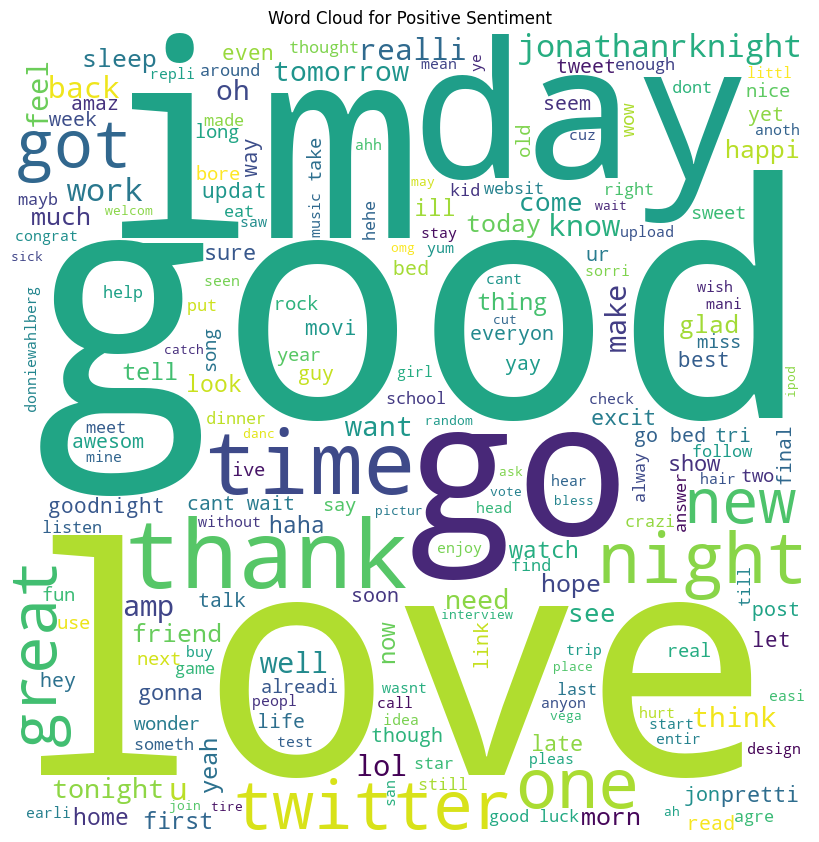

In [59]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud for Positive Sentiment")
plt.show()

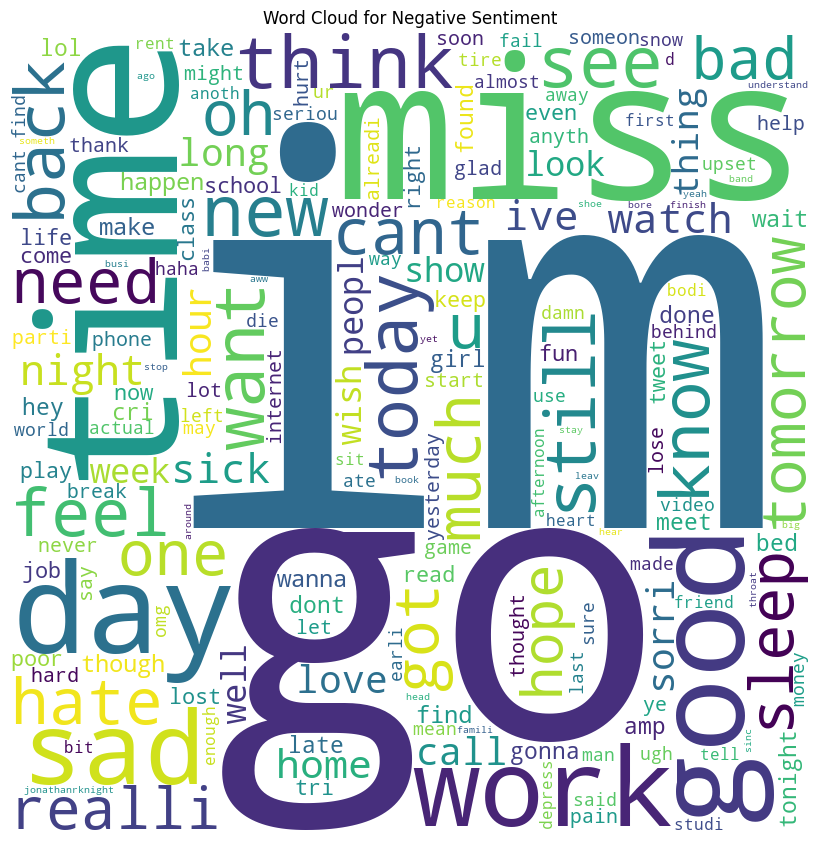

In [60]:
# Plotting the Negative Sentiment WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud for Negative Sentiment")
plt.show()

Storing the dataframe in a parquet file. This will be used to train the model

In [30]:
import shutil
try:
    sentiment140.write.parquet("../data-processed/sentiment140_model_data.parquet")
except:
    print('Directory already exists at path...\nDeleting the directory')
    shutil.rmtree('../data-processed/sentiment140_model_data.parquet')
    sentiment140.write.parquet("../data-processed/sentiment140_model_data.parquet")

Directory already exists at path...
Deleting the directory
